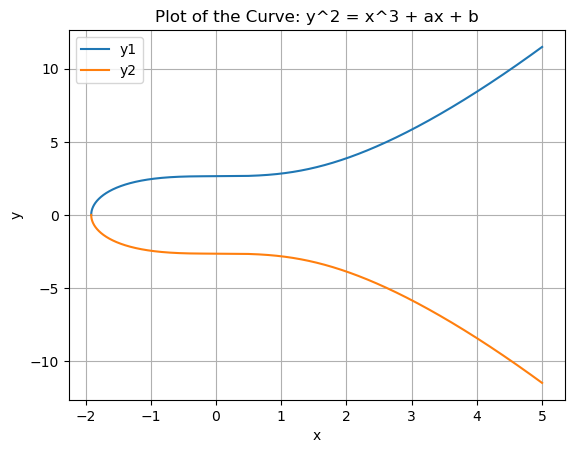

0

In [81]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import math as m


## We used the dataclass decorator to create a class with a lot of methods that are useful for working with data classes.
@dataclass
class Curve:
    """
    Elliptic curve over the field of integers modulo a prime.
    Points on the curve satisfy y^2 = x^3 + a*x + b (mod p).
    """
    p:int
    a:int
    b:int
    
bitcoin_curve=Curve(
    p=0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFC2F, #p=115792089237316195423570985008687907853269984665640564039457584007908834671663
    a = 0x0000000000000000000000000000000000000000000000000000000000000000, # a = 0
    b = 0x0000000000000000000000000000000000000000000000000000000000000007, #b = 0
)

###Just for visualization we are gonna draw the elliptic curve

def draw_curve(curve:Curve):
    n_xs = 100000
    xs = np.linspace(-np.power(7, 1/3), 5, n_xs)
    ys_squared = xs**3 + curve.a*xs + curve.b
    ys = np.sqrt(np.abs(ys_squared)) * np.sign(ys_squared)  # Compute y values, handling negative values

    plt.plot(xs, ys, label='y1')
    plt.plot(xs, -ys, label='y2')  # Mirror image of the curve
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Plot of the Curve: y^2 = x^3 + ax + b')
    plt.legend()
    plt.grid(True)
    plt.show()
    return 0


draw_curve(bitcoin_curve)
    
    

# Generator Point
Oltre alla definizione della curva di BTC definiamo un generator point che è uno starting point fisso nella curva, e viene usato per far partire la random walk sulla curva.
Il Generator Point è una costante conosciuta e di cui tutti sappiamo il valore.

Per ulteriori informazioni: [How does ECDSA work in Bitcoin](https://medium.com/@blairlmarshall/how-does-ecdsa-work-in-bitcoin-7819d201a3ec)

In [82]:
@dataclass
class Point:
    """An integer point (x,y) on a Curve"""
    curve:Curve
    x:int
    y:int
    
G=Point(
    curve=bitcoin_curve,
    x=0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798,## in normal base 10: 55066263022277343669578718895168534326250603453777594175500187360389116729240
    y=0x483ADA7726A3C4655DA4FBFC0E1108A8FD17B448A68554199C47D08FFB10D4B8 ## in normal base 10: 32670510020758816978083085130507043184471273380659243275938904335757337482424
)

def is_on_curve(point:Point)->bool:
    """Returns True if the given point lies on the curve, and False otherwise."""
    curve = point.curve
    return (point.y**2 - point.x**3 - curve.a*point.x - curve.b) % curve.p == 0

import random
# We are gonna test the function is_on_curve with a random point
#print(is_on_curve(Point(bitcoin_curve, x=random.randrange(0,bitcoin_curve.p), y=random.randrange(0,bitcoin_curve.p))))
# We are gonna test the function is_on_curve with the generator point
#print(is_on_curve(G))

In [83]:
@dataclass
class Generator:
    """A generator for a curve: a point and the order of that point"""
    G:Point
    ## The order of the point G is the number of points on the curve that can be generated by adding G to itself a number of times
    ## until the result is the point at infinity, denoted O. so 0*G=n*G= INF
    n:int
    
bitcoin_gen=Generator(
    G=G,
    n=0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEBAAEDCE6AF48A03BBFD25E8CD0364141 ## in normal base 10: 115792089237316195423570985008687907852837564279074904382605163141518161494337
)



Ora abbiamo l'ordine del generator, quindi il numero massimo di volte che possiamo sommare G a se stesso e rimanere nella curva.

Quindi ogni numero <=n può essere considerato come una sorta di "chiave" per G.

La "Secret Key" di bitcoin non è altro che un numero compreso tra 0<=P_K<=n.

In [84]:
secret_key=int.from_bytes(b'Andrej is cool :P','big') ## Useremo questa stringa per generare la chiave privata
print(secret_key)

assert 1 <= secret_key < bitcoin_gen.n, "Secret key is out of range"



22265090479312778178772228083027296664144


# Generare la chiave pubblica
La chiave pubblica è il punto nella curva di BTC che si ottiene aggiungendo il punto generatore a se stesso una quantità di volte pari alla secret key.

La chiave prvate è un intero, ma il punto generatore è una tupla,cioè un punto nella curva.

Il punto secret_key*G sulla curva quindi è anche esso una tupla.

Quindi ora bisogna definire il concetto di somma su una curva ellittica

In [85]:
INF=Point(None, x=None, y=None) ## Il punto all'infinito, che è l'elemento neutro dell'addizione sulle curve ellittiche

def extended_euclidean_algorithm(a:int,b:int) -> list:
    """
    Restituisce il Massimo Comune Divisore tra a e b, e i coefficienti x e y tali che ax+by=gcd(a,b)
    L'algoritmo nel suo caso peggiore gira in O(log(min(a,b)))
    """
    
    old_r,r= a,b
    old_s,s=1,0
    old_t,t=0,1
    while r!=0:
        q=old_r//r
        old_r,r=r,old_r-q*r
        old_s,s=s,old_s-q*s
        old_t,t=t,old_t-q*t
    return [old_r,old_s,old_t]


def inv(n,p):
    """ REstituisce l'inverso di n modulo p, cioè n*m=1 mod p"""
    gcd,x,y=extended_euclidean_algorithm(n,p)
    #assert (n*x+p*y)==gcd
    #assert gcd==1
    return x%p


def elliptic_curve_addition(self,other:Point)->Point:
    """Addition of two points on an elliptic curve."""
    ## Handle special case of P + 0 = 0 + P = 0
    if self==INF:
        return other
    
    if other==INF:
        return self

    ## Gestiamo il caso P + (-P) = 0
    if self.x==other.x and self.y!=other.y:
        return INF
    
    ## Dobbiamo calcolare la pendenza della retta che passa per i due punti
    if self.x==other.x: ## Il caso self.y==other.y è garantito dall'if precedente
        m=(3*self.x**2+self.curve.a)*inv(2*self.y,self.curve.p)
    else:
        m=(self.y-other.y)*inv(self.x-other.x,self.curve.p)
        
    ## Creiamo il nuovo punto
    rx=(m**2-self.x-other.x)%self.curve.p
    ry=(m*(self.x-rx)-self.y)%self.curve.p
    return Point(self.curve,rx,ry)


Point.__add__=elliptic_curve_addition ## Aggiungiamo il metodo di somma alla classe Point
    
    
    

# Commento:

La derivazione dell'operazione algebrica di somma di punti è un po complicata, ma dobbiamo ricordarci che siamo in un campo di numeri interi cioè siamo in un insieme che contiene solo i numeri da 1 al numero primo scelto per la curva.



In [86]:
## Definiamo la moltiplicazione scalare
def scalar_multiplication(self,n:int)->Point:
    res=INF
    for i in range(n):
        res+=self
    return res



#Point.__rmul__=scalar_multiplication ## Aggiungiamo il metodo di moltiplicazione scalare alla classe Point

In [87]:


def double_and_add(self,n:int)->Point:
    res=INF
    addend=self
    while n:
        if n&1:
            res+=addend
        addend+=addend
        n>>=1
 
    return res

Point.__rmul__=double_and_add ## Aggiungiamo il metodo di moltiplicazione scalare alla classe Point


22265090479312778178772228083027296664144*G

0


Point(curve=Curve(p=115792089237316195423570985008687907853269984665640564039457584007908834671663, a=0, b=7), x=83998262154709529558614902604110599582969848537757180553516367057821848015989, y=37676469766173670826348691885774454391218658108212372128812329274086400588247)

# Commento:
L'uso di scalar_multiplication va benissimo, per numeri piccoli.
Nel caso di numeri tipo 22265090479312778178772228083027296664144, essendo che viene eseguito in tempo lineare deve fare 22265090479312778178772228083027296664144 iterazioni.
Su un computer con un processore a 5GHz questa cosa richiederebbe 4.4530180958625557e+30 secondi, ciò significa circa 1000 miliardi di volte l'età dell'universo.

L'operatore >>= è l'operatore che shifta di uno il numero binario, cioè lo divide per 2 ignorando il resto.
Questo porta da 22265090479312778178772228083027296664144 iterazioni a 137, che un pc normale svolge in pochi centesimi di secondo




In [221]:
##TODO Implementare a mano la funzione di Hashing SHA256
def gen_sha256_with_variable_scope_protector_to_not_pollute_global_namespace(message:str)->str:
    raise NotImplementedError

def gen_sha256_with_variable_scope_protector_to_not_pollute_global_namespace():
    
    """
    SHA256 implementation.
    
    Follows the FIPS PUB 180-4 description for calculating SHA-256 hash function
    https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf

    Noone in their right mind should use this for any serious reason. This was written
    purely for educational purposes.
    """

    import math
    from itertools import count, islice

    # -----------------------------------------------------------------------------
    # SHA-256 Functions, defined in Section 4

    def rotr(x, n, size=32):
        return (x >> n) | (x << size - n) & (2**size - 1)

    def shr(x, n):
        return x >> n

    def sig0(x):
        return rotr(x, 7) ^ rotr(x, 18) ^ shr(x, 3)

    def sig1(x):
        return rotr(x, 17) ^ rotr(x, 19) ^ shr(x, 10)

    def capsig0(x):
        return rotr(x, 2) ^ rotr(x, 13) ^ rotr(x, 22)

    def capsig1(x):
        return rotr(x, 6) ^ rotr(x, 11) ^ rotr(x, 25)

    def ch(x, y, z):
        return (x & y)^ (~x & z)

    def maj(x, y, z):
        return (x & y) ^ (x & z) ^ (y & z)

    def b2i(b):
        return int.from_bytes(b, 'big')

    def i2b(i):
        return i.to_bytes(4, 'big')

    # -----------------------------------------------------------------------------
    # SHA-256 Constants

    def is_prime(n):
        return not any(f for f in range(2,int(math.sqrt(n))+1) if n%f == 0)

    def first_n_primes(n):
        return islice(filter(is_prime, count(start=2)), n)

    def frac_bin(f, n=32):
        """ return the first n bits of fractional part of float f """
        f -= math.floor(f) # get only the fractional part
        f *= 2**n # shift left
        f = int(f) # truncate the rest of the fractional content
        return f

    def genK():
        """
        Follows Section 4.2.2 to generate K

        The first 32 bits of the fractional parts of the cube roots of the first
        64 prime numbers:

        428a2f98 71374491 b5c0fbcf e9b5dba5 3956c25b 59f111f1 923f82a4 ab1c5ed5
        d807aa98 12835b01 243185be 550c7dc3 72be5d74 80deb1fe 9bdc06a7 c19bf174
        e49b69c1 efbe4786 0fc19dc6 240ca1cc 2de92c6f 4a7484aa 5cb0a9dc 76f988da
        983e5152 a831c66d b00327c8 bf597fc7 c6e00bf3 d5a79147 06ca6351 14292967
        27b70a85 2e1b2138 4d2c6dfc 53380d13 650a7354 766a0abb 81c2c92e 92722c85
        a2bfe8a1 a81a664b c24b8b70 c76c51a3 d192e819 d6990624 f40e3585 106aa070
        19a4c116 1e376c08 2748774c 34b0bcb5 391c0cb3 4ed8aa4a 5b9cca4f 682e6ff3
        748f82ee 78a5636f 84c87814 8cc70208 90befffa a4506ceb bef9a3f7 c67178f2
        """
        return [frac_bin(p ** (1/3.0)) for p in first_n_primes(64)]

    def genH():
        """
        Follows Section 5.3.3 to generate the initial hash value H^0

        The first 32 bits of the fractional parts of the square roots of
        the first 8 prime numbers.

        6a09e667 bb67ae85 3c6ef372 a54ff53a 9b05688c 510e527f 1f83d9ab 5be0cd19
        """
        return [frac_bin(p ** (1/2.0)) for p in first_n_primes(8)]

    # -----------------------------------------------------------------------------

    def pad(b):
        """ Follows Section 5.1: Padding the message """
        b = bytearray(b) # convert to a mutable equivalent
        l = len(b) * 8 # note: len returns number of bytes not bits

        # append but "1" to the end of the message
        b.append(0b10000000) # appending 10000000 in binary (=128 in decimal)

        # follow by k zero bits, where k is the smallest non-negative solution to
        # l + 1 + k = 448 mod 512
        # i.e. pad with zeros until we reach 448 (mod 512)
        while (len(b)*8) % 512 != 448:
            b.append(0x00)

        # the last 64-bit block is the length l of the original message
        # expressed in binary (big endian)
        b.extend(l.to_bytes(8, 'big'))

        return b

    def sha256(b: bytes) -> bytes:

        # Section 4.2
        K = genK()

        # Section 5: Preprocessing
        # Section 5.1: Pad the message
        b = pad(b)
        # Section 5.2: Separate the message into blocks of 512 bits (64 bytes)
        blocks = [b[i:i+64] for i in range(0, len(b), 64)]

        # for each message block M^1 ... M^N
        H = genH() # Section 5.3

        # Section 6
        for M in blocks: # each block is a 64-entry array of 8-bit bytes

            # 1. Prepare the message schedule, a 64-entry array of 32-bit words
            W = []
            for t in range(64):
                if t <= 15:
                    # the first 16 words are just a copy of the block
                    W.append(bytes(M[t*4:t*4+4]))
                else:
                    term1 = sig1(b2i(W[t-2]))
                    term2 = b2i(W[t-7])
                    term3 = sig0(b2i(W[t-15]))
                    term4 = b2i(W[t-16])
                    total = (term1 + term2 + term3 + term4) % 2**32
                    W.append(i2b(total))

            # 2. Initialize the 8 working variables a,b,c,d,e,f,g,h with prev hash value
            a, b, c, d, e, f, g, h = H

            # 3.
            for t in range(64):
                T1 = (h + capsig1(e) + ch(e, f, g) + K[t] + b2i(W[t])) % 2**32
                T2 = (capsig0(a) + maj(a, b, c)) % 2**32
                h = g
                g = f
                f = e
                e = (d + T1) % 2**32
                d = c
                c = b
                b = a
                a = (T1 + T2) % 2**32

            # 4. Compute the i-th intermediate hash value H^i
            delta = [a, b, c, d, e, f, g, h]
            H = [(i1 + i2) % 2**32 for i1, i2 in zip(H, delta)]

        return b''.join(i2b(i) for i in H)
    
    return sha256

sha256 = gen_sha256_with_variable_scope_protector_to_not_pollute_global_namespace()
print("verify empty hash:", sha256(b'').hex()) # should be e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855
print(sha256(b'Ho barato cazzo').hex())
print("number of bytes in a sha256 digest: ", len(sha256(b'')))

def gen_ripemd160_with_variable_scope_protector_to_not_pollute_global_namespace():
    
    import sys
    import struct

    # -----------------------------------------------------------------------------
    # public interface

    def ripemd160(b: bytes) -> bytes:
        """ simple wrapper for a simpler API to this hash function, just bytes to bytes """
        ctx = RMDContext()
        RMD160Update(ctx, b, len(b))
        digest = RMD160Final(ctx)
        return digest

    # -----------------------------------------------------------------------------

    class RMDContext:
        def __init__(self):
            self.state = [0x67452301, 0xEFCDAB89, 0x98BADCFE, 0x10325476, 0xC3D2E1F0] # uint32
            self.count = 0 # uint64
            self.buffer = [0]*64 # uchar

    def RMD160Update(ctx, inp, inplen):
        have = int((ctx.count // 8) % 64)
        inplen = int(inplen)
        need = 64 - have
        ctx.count += 8 * inplen
        off = 0
        if inplen >= need:
            if have:
                for i in range(need):
                    ctx.buffer[have+i] = inp[i]
                RMD160Transform(ctx.state, ctx.buffer)
                off = need
                have = 0
            while off + 64 <= inplen:
                RMD160Transform(ctx.state, inp[off:])
                off += 64
        if off < inplen:
            for i in range(inplen - off):
                ctx.buffer[have+i] = inp[off+i]

    def RMD160Final(ctx):
        size = struct.pack("<Q", ctx.count)
        padlen = 64 - ((ctx.count // 8) % 64)
        if padlen < 1 + 8:
            padlen += 64
        RMD160Update(ctx, PADDING, padlen-8)
        RMD160Update(ctx, size, 8)
        return struct.pack("<5L", *ctx.state)

    # -----------------------------------------------------------------------------

    K0 = 0x00000000
    K1 = 0x5A827999
    K2 = 0x6ED9EBA1
    K3 = 0x8F1BBCDC
    K4 = 0xA953FD4E
    KK0 = 0x50A28BE6
    KK1 = 0x5C4DD124
    KK2 = 0x6D703EF3
    KK3 = 0x7A6D76E9
    KK4 = 0x00000000

    PADDING = [0x80] + [0]*63

    def ROL(n, x):
        return ((x << n) & 0xffffffff) | (x >> (32 - n))

    def F0(x, y, z):
        return x ^ y ^ z

    def F1(x, y, z):
        return (x & y) | (((~x) % 0x100000000) & z)

    def F2(x, y, z):
        return (x | ((~y) % 0x100000000)) ^ z

    def F3(x, y, z):
        return (x & z) | (((~z) % 0x100000000) & y)

    def F4(x, y, z):
        return x ^ (y | ((~z) % 0x100000000))

    def R(a, b, c, d, e, Fj, Kj, sj, rj, X):
        a = ROL(sj, (a + Fj(b, c, d) + X[rj] + Kj) % 0x100000000) + e
        c = ROL(10, c)
        return a % 0x100000000, c

    def RMD160Transform(state, block): #uint32 state[5], uchar block[64]

        x = [0]*16
        assert sys.byteorder == 'little', "Only little endian is supported atm for RIPEMD160"
        x = struct.unpack('<16L', bytes(block[0:64]))

        a = state[0]
        b = state[1]
        c = state[2]
        d = state[3]
        e = state[4]

        #/* Round 1 */
        a, c = R(a, b, c, d, e, F0, K0, 11,  0, x)
        e, b = R(e, a, b, c, d, F0, K0, 14,  1, x)
        d, a = R(d, e, a, b, c, F0, K0, 15,  2, x)
        c, e = R(c, d, e, a, b, F0, K0, 12,  3, x)
        b, d = R(b, c, d, e, a, F0, K0,  5,  4, x)
        a, c = R(a, b, c, d, e, F0, K0,  8,  5, x)
        e, b = R(e, a, b, c, d, F0, K0,  7,  6, x)
        d, a = R(d, e, a, b, c, F0, K0,  9,  7, x)
        c, e = R(c, d, e, a, b, F0, K0, 11,  8, x)
        b, d = R(b, c, d, e, a, F0, K0, 13,  9, x)
        a, c = R(a, b, c, d, e, F0, K0, 14, 10, x)
        e, b = R(e, a, b, c, d, F0, K0, 15, 11, x)
        d, a = R(d, e, a, b, c, F0, K0,  6, 12, x)
        c, e = R(c, d, e, a, b, F0, K0,  7, 13, x)
        b, d = R(b, c, d, e, a, F0, K0,  9, 14, x)
        a, c = R(a, b, c, d, e, F0, K0,  8, 15, x) #/* #15 */
        #/* Round 2 */
        e, b = R(e, a, b, c, d, F1, K1,  7,  7, x)
        d, a = R(d, e, a, b, c, F1, K1,  6,  4, x)
        c, e = R(c, d, e, a, b, F1, K1,  8, 13, x)
        b, d = R(b, c, d, e, a, F1, K1, 13,  1, x)
        a, c = R(a, b, c, d, e, F1, K1, 11, 10, x)
        e, b = R(e, a, b, c, d, F1, K1,  9,  6, x)
        d, a = R(d, e, a, b, c, F1, K1,  7, 15, x)
        c, e = R(c, d, e, a, b, F1, K1, 15,  3, x)
        b, d = R(b, c, d, e, a, F1, K1,  7, 12, x)
        a, c = R(a, b, c, d, e, F1, K1, 12,  0, x)
        e, b = R(e, a, b, c, d, F1, K1, 15,  9, x)
        d, a = R(d, e, a, b, c, F1, K1,  9,  5, x)
        c, e = R(c, d, e, a, b, F1, K1, 11,  2, x)
        b, d = R(b, c, d, e, a, F1, K1,  7, 14, x)
        a, c = R(a, b, c, d, e, F1, K1, 13, 11, x)
        e, b = R(e, a, b, c, d, F1, K1, 12,  8, x) #/* #31 */
        #/* Round 3 */
        d, a = R(d, e, a, b, c, F2, K2, 11,  3, x)
        c, e = R(c, d, e, a, b, F2, K2, 13, 10, x)
        b, d = R(b, c, d, e, a, F2, K2,  6, 14, x)
        a, c = R(a, b, c, d, e, F2, K2,  7,  4, x)
        e, b = R(e, a, b, c, d, F2, K2, 14,  9, x)
        d, a = R(d, e, a, b, c, F2, K2,  9, 15, x)
        c, e = R(c, d, e, a, b, F2, K2, 13,  8, x)
        b, d = R(b, c, d, e, a, F2, K2, 15,  1, x)
        a, c = R(a, b, c, d, e, F2, K2, 14,  2, x)
        e, b = R(e, a, b, c, d, F2, K2,  8,  7, x)
        d, a = R(d, e, a, b, c, F2, K2, 13,  0, x)
        c, e = R(c, d, e, a, b, F2, K2,  6,  6, x)
        b, d = R(b, c, d, e, a, F2, K2,  5, 13, x)
        a, c = R(a, b, c, d, e, F2, K2, 12, 11, x)
        e, b = R(e, a, b, c, d, F2, K2,  7,  5, x)
        d, a = R(d, e, a, b, c, F2, K2,  5, 12, x) #/* #47 */
        #/* Round 4 */
        c, e = R(c, d, e, a, b, F3, K3, 11,  1, x)
        b, d = R(b, c, d, e, a, F3, K3, 12,  9, x)
        a, c = R(a, b, c, d, e, F3, K3, 14, 11, x)
        e, b = R(e, a, b, c, d, F3, K3, 15, 10, x)
        d, a = R(d, e, a, b, c, F3, K3, 14,  0, x)
        c, e = R(c, d, e, a, b, F3, K3, 15,  8, x)
        b, d = R(b, c, d, e, a, F3, K3,  9, 12, x)
        a, c = R(a, b, c, d, e, F3, K3,  8,  4, x)
        e, b = R(e, a, b, c, d, F3, K3,  9, 13, x)
        d, a = R(d, e, a, b, c, F3, K3, 14,  3, x)
        c, e = R(c, d, e, a, b, F3, K3,  5,  7, x)
        b, d = R(b, c, d, e, a, F3, K3,  6, 15, x)
        a, c = R(a, b, c, d, e, F3, K3,  8, 14, x)
        e, b = R(e, a, b, c, d, F3, K3,  6,  5, x)
        d, a = R(d, e, a, b, c, F3, K3,  5,  6, x)
        c, e = R(c, d, e, a, b, F3, K3, 12,  2, x) #/* #63 */
        #/* Round 5 */
        b, d = R(b, c, d, e, a, F4, K4,  9,  4, x)
        a, c = R(a, b, c, d, e, F4, K4, 15,  0, x)
        e, b = R(e, a, b, c, d, F4, K4,  5,  5, x)
        d, a = R(d, e, a, b, c, F4, K4, 11,  9, x)
        c, e = R(c, d, e, a, b, F4, K4,  6,  7, x)
        b, d = R(b, c, d, e, a, F4, K4,  8, 12, x)
        a, c = R(a, b, c, d, e, F4, K4, 13,  2, x)
        e, b = R(e, a, b, c, d, F4, K4, 12, 10, x)
        d, a = R(d, e, a, b, c, F4, K4,  5, 14, x)
        c, e = R(c, d, e, a, b, F4, K4, 12,  1, x)
        b, d = R(b, c, d, e, a, F4, K4, 13,  3, x)
        a, c = R(a, b, c, d, e, F4, K4, 14,  8, x)
        e, b = R(e, a, b, c, d, F4, K4, 11, 11, x)
        d, a = R(d, e, a, b, c, F4, K4,  8,  6, x)
        c, e = R(c, d, e, a, b, F4, K4,  5, 15, x)
        b, d = R(b, c, d, e, a, F4, K4,  6, 13, x) #/* #79 */

        aa = a
        bb = b
        cc = c
        dd = d
        ee = e

        a = state[0]
        b = state[1]
        c = state[2]
        d = state[3]
        e = state[4]

        #/* Parallel round 1 */
        a, c = R(a, b, c, d, e, F4, KK0,  8,  5, x)
        e, b = R(e, a, b, c, d, F4, KK0,  9, 14, x)
        d, a = R(d, e, a, b, c, F4, KK0,  9,  7, x)
        c, e = R(c, d, e, a, b, F4, KK0, 11,  0, x)
        b, d = R(b, c, d, e, a, F4, KK0, 13,  9, x)
        a, c = R(a, b, c, d, e, F4, KK0, 15,  2, x)
        e, b = R(e, a, b, c, d, F4, KK0, 15, 11, x)
        d, a = R(d, e, a, b, c, F4, KK0,  5,  4, x)
        c, e = R(c, d, e, a, b, F4, KK0,  7, 13, x)
        b, d = R(b, c, d, e, a, F4, KK0,  7,  6, x)
        a, c = R(a, b, c, d, e, F4, KK0,  8, 15, x)
        e, b = R(e, a, b, c, d, F4, KK0, 11,  8, x)
        d, a = R(d, e, a, b, c, F4, KK0, 14,  1, x)
        c, e = R(c, d, e, a, b, F4, KK0, 14, 10, x)
        b, d = R(b, c, d, e, a, F4, KK0, 12,  3, x)
        a, c = R(a, b, c, d, e, F4, KK0,  6, 12, x) #/* #15 */
        #/* Parallel round 2 */
        e, b = R(e, a, b, c, d, F3, KK1,  9,  6, x)
        d, a = R(d, e, a, b, c, F3, KK1, 13, 11, x)
        c, e = R(c, d, e, a, b, F3, KK1, 15,  3, x)
        b, d = R(b, c, d, e, a, F3, KK1,  7,  7, x)
        a, c = R(a, b, c, d, e, F3, KK1, 12,  0, x)
        e, b = R(e, a, b, c, d, F3, KK1,  8, 13, x)
        d, a = R(d, e, a, b, c, F3, KK1,  9,  5, x)
        c, e = R(c, d, e, a, b, F3, KK1, 11, 10, x)
        b, d = R(b, c, d, e, a, F3, KK1,  7, 14, x)
        a, c = R(a, b, c, d, e, F3, KK1,  7, 15, x)
        e, b = R(e, a, b, c, d, F3, KK1, 12,  8, x)
        d, a = R(d, e, a, b, c, F3, KK1,  7, 12, x)
        c, e = R(c, d, e, a, b, F3, KK1,  6,  4, x)
        b, d = R(b, c, d, e, a, F3, KK1, 15,  9, x)
        a, c = R(a, b, c, d, e, F3, KK1, 13,  1, x)
        e, b = R(e, a, b, c, d, F3, KK1, 11,  2, x) #/* #31 */
        #/* Parallel round 3 */
        d, a = R(d, e, a, b, c, F2, KK2,  9, 15, x)
        c, e = R(c, d, e, a, b, F2, KK2,  7,  5, x)
        b, d = R(b, c, d, e, a, F2, KK2, 15,  1, x)
        a, c = R(a, b, c, d, e, F2, KK2, 11,  3, x)
        e, b = R(e, a, b, c, d, F2, KK2,  8,  7, x)
        d, a = R(d, e, a, b, c, F2, KK2,  6, 14, x)
        c, e = R(c, d, e, a, b, F2, KK2,  6,  6, x)
        b, d = R(b, c, d, e, a, F2, KK2, 14,  9, x)
        a, c = R(a, b, c, d, e, F2, KK2, 12, 11, x)
        e, b = R(e, a, b, c, d, F2, KK2, 13,  8, x)
        d, a = R(d, e, a, b, c, F2, KK2,  5, 12, x)
        c, e = R(c, d, e, a, b, F2, KK2, 14,  2, x)
        b, d = R(b, c, d, e, a, F2, KK2, 13, 10, x)
        a, c = R(a, b, c, d, e, F2, KK2, 13,  0, x)
        e, b = R(e, a, b, c, d, F2, KK2,  7,  4, x)
        d, a = R(d, e, a, b, c, F2, KK2,  5, 13, x) #/* #47 */
        #/* Parallel round 4 */
        c, e = R(c, d, e, a, b, F1, KK3, 15,  8, x)
        b, d = R(b, c, d, e, a, F1, KK3,  5,  6, x)
        a, c = R(a, b, c, d, e, F1, KK3,  8,  4, x)
        e, b = R(e, a, b, c, d, F1, KK3, 11,  1, x)
        d, a = R(d, e, a, b, c, F1, KK3, 14,  3, x)
        c, e = R(c, d, e, a, b, F1, KK3, 14, 11, x)
        b, d = R(b, c, d, e, a, F1, KK3,  6, 15, x)
        a, c = R(a, b, c, d, e, F1, KK3, 14,  0, x)
        e, b = R(e, a, b, c, d, F1, KK3,  6,  5, x)
        d, a = R(d, e, a, b, c, F1, KK3,  9, 12, x)
        c, e = R(c, d, e, a, b, F1, KK3, 12,  2, x)
        b, d = R(b, c, d, e, a, F1, KK3,  9, 13, x)
        a, c = R(a, b, c, d, e, F1, KK3, 12,  9, x)
        e, b = R(e, a, b, c, d, F1, KK3,  5,  7, x)
        d, a = R(d, e, a, b, c, F1, KK3, 15, 10, x)
        c, e = R(c, d, e, a, b, F1, KK3,  8, 14, x) #/* #63 */
        #/* Parallel round 5 */
        b, d = R(b, c, d, e, a, F0, KK4,  8, 12, x)
        a, c = R(a, b, c, d, e, F0, KK4,  5, 15, x)
        e, b = R(e, a, b, c, d, F0, KK4, 12, 10, x)
        d, a = R(d, e, a, b, c, F0, KK4,  9,  4, x)
        c, e = R(c, d, e, a, b, F0, KK4, 12,  1, x)
        b, d = R(b, c, d, e, a, F0, KK4,  5,  5, x)
        a, c = R(a, b, c, d, e, F0, KK4, 14,  8, x)
        e, b = R(e, a, b, c, d, F0, KK4,  6,  7, x)
        d, a = R(d, e, a, b, c, F0, KK4,  8,  6, x)
        c, e = R(c, d, e, a, b, F0, KK4, 13,  2, x)
        b, d = R(b, c, d, e, a, F0, KK4,  6, 13, x)
        a, c = R(a, b, c, d, e, F0, KK4,  5, 14, x)
        e, b = R(e, a, b, c, d, F0, KK4, 15,  0, x)
        d, a = R(d, e, a, b, c, F0, KK4, 13,  3, x)
        c, e = R(c, d, e, a, b, F0, KK4, 11,  9, x)
        b, d = R(b, c, d, e, a, F0, KK4, 11, 11, x) #/* #79 */

        t = (state[1] + cc + d) % 0x100000000
        state[1] = (state[2] + dd + e) % 0x100000000
        state[2] = (state[3] + ee + a) % 0x100000000
        state[3] = (state[4] + aa + b) % 0x100000000
        state[4] = (state[0] + bb + c) % 0x100000000
        state[0] = t % 0x100000000
    
    return ripemd160
    
ripemd160 = gen_ripemd160_with_variable_scope_protector_to_not_pollute_global_namespace()
print(ripemd160(b'hello this is a test').hex())
print("number of bytes in a RIPEMD-160 digest: ", len(ripemd160(b'')))

## La funzione in se non è niente di spaventoso, è solo un po' lunga e noiosa da scrivere. Però è molto importante perchè restituisce sempre lo stesso output per lo stesso input, e quindi è deterministica. Questo è fondamentale per la sicurezza delle firme digitali.
## Inoltre è molto difficile trovare due messaggi diversi che hanno lo stesso hash, genera una stringa di lunghezza fissa, e non è reversibile, cioè non è possibile risalire al messaggio originale partendo dall'hash.
## 


verify empty hash: e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855
5247e68a5c0b33cbc9eb9585cb2a1ada3c4a65dbbdc8d0f47dc93facaa8bd41d
number of bytes in a sha256 digest:  32
f51960af7dd4813a587ab26388ddab3b28d1f7b4
number of bytes in a RIPEMD-160 digest:  20


In [262]:
## Bariamo un po e importiamo le dipendenze per calcolare l'hash della stringa
import hashlib
def gen_sha256(message:str)->str:
    return hashlib.sha256(message).digest()

## Testiamo la funzione di hashing
print(gen_sha256('Ho barato cazzo').digest())
print(sha256(b'Ho barato cazzo'))

TypeError: Strings must be encoded before hashing

In [268]:
# importiamo CryptoHash
#! pip install pycryptodome
from Crypto.Hash import RIPEMD160

def gen_ripemd160(message:str)->str:
    h = RIPEMD160.new()
    h.update(message) 
    return h.digest()

## Testiamo la funzione di hashing



Manca l'implementazione di b58encoding, cioè l'algoritmo specifico a BTC che usa la base 58,che sono i caratteri dell'alfabeto che non sono ambigui, cioè toglie "0" e "O", oppure "I" e "l".
quindi dobbiamo prendere il nostro btc address e convertirlo da 25 bytes in 58 bytes.

In [269]:
alphabet = '123456789ABCDEFGHJKLMNPQRSTUVWXYZabcdefghijkmnopqrstuvwxyz'

def b58encode(b: bytes) -> str:
    assert len(b) == 25, f"{len(b)}" # version is 1 byte, pkb_hash 20 bytes, checksum 4 bytes
    n = int.from_bytes(b, 'big')
    chars = []
    while n:
        n, i = divmod(n, 58)
        chars.append(alphabet[i])
    # special case handle the leading 0 bytes... ¯\_(ツ)_/¯
    num_leading_zeros = len(b) - len(b.lstrip(b'\x00'))
    res = num_leading_zeros * alphabet[0] + ''.join(reversed(chars))
    return res


class PublicKey(Point):
    """
    La chiave pubblica è un punto sulla curva ellittica, e quindi estende la classe Point, 
    però ha qualche funzionalità in più di encoding e decoding che implementiamo qui.
    
    """
    @classmethod
    def from_point(cls,point:Point):
        """Promuove un punto a chiave pubblica."""
        return cls(point.curve,point.x,point.y)
    
    def encode(self,compressed,hash160=False):
        """
        Encode the public key as a byte string.
        The byte string can be compressed or uncompressed.
        """
        if compressed:
            #(x,y) può essere molto ridondante, quindi possiamo comprimerlo, infatti y^2 = x^3 + 7,
            # quindi se sappiamo x, possiamo calcolare y come la radice quadrata di x^3+7
            # e poi scegliere tra la radice positiva e negativa. Ma questo ci è permesso dal prefisso, che ci dice quale delle due radici scegliere.
            # Infatti se y è pari, scegliamo la radice positiva, altrimenti la negativa.
            #Perchè nell'aritmetica modulare si può dimostrare che una è pari e l altra è dipari.
            prefix = b'\x02' if self.y % 2 == 0 else b'\x03'
            pkb =prefix + self.x.to_bytes(32, 'big')
        else:
            prefix = b'\x04'
            pkb=prefix + self.x.to_bytes(32, 'big') + self.y.to_bytes(32, 'big')
            
        
        tmp=gen_ripemd160(gen_sha256(pkb))
            
        return tmp if hash160 else pkb
    
    def address(self,net: str,compressed: bool) -> str:
        """Restituisce l'indirizzo bitcoin corrispondente alla chiave pubblica."""
        # 1. Calcoliamo l'hash160 della chiave pubblica
        pkb_hash = self.encode(compressed, hash160=True)
        # 2. Aggiungiamo il byte di versione (0x00 per il mainnet, 0x6f per il testnet)
        version = {'main': b'\x00', 'test': b'\x6f'}

        
        ver_pkb_hash = version[net] + pkb_hash
        # 3. Calcoliamo il checksum
        checksum = sha256(sha256(ver_pkb_hash))[:4]
        # 4. Concateniamo il ver_pkb_hash e il checksum
        
        address =ver_pkb_hash+ checksum
      
        # 5. Convertiamo in base58
        b58check_address = b58encode(address)
        return b58check_address
    
   


In [271]:
address = PublicKey.from_point(public_key).address(net='test', compressed=True)
print(address)


mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ


## Parte2: BTC come funziona, invio e ricezione di fondi
Creiamo un wallet che possa ricevere i bitcoin

In [274]:
secret_key2= int.from_bytes(b'Chiave super segreta', 'big')
assert secret_key2 <= bitcoin_gen.n, "Chiave troppo grande"   

public_key2 = secret_key2 * bitcoin_gen.G
public_key2

0


Point(curve=Curve(p=115792089237316195423570985008687907853269984665640564039457584007908834671663, a=0, b=7), x=24500931825217727143845519007918719852346024512362351154507582071995438590005, y=40718142066445498470618585470280639134995674152785427738097376428071267486472)

In [278]:
address2 = PublicKey.from_point(public_key2).address(net='test', compressed=True)
address2

'n3A5bGYm5q3fStXRvsmRkcjarvot5q99ZQ'

Abbiamo creato due addresses della rete di test di bitcoin, ora implementiamo le transazioni tra di loro

In [284]:
@dataclass
class TxIn:
    prev_tx: bytes
    prev_index: int
    script_sig: Script = None
    sequence: int = 0xffffffff
    
    
tx_in=TxIn(prev_tx='46325085c89fb98a4b7ceee44eac9b955f09e1ddc86d8dad3dfdcba46b4d36b2',
           prev_index=0, 
           script_sig=None, 
           )

In [283]:
@dataclass
class TxOut:
    amount: int
    script_pubkey: Script = None   
    
tx_out1=TxOut(amount=50000)
tx_out2=TxOut(amount=47500)

In [288]:
def encode_int(i, nbytes, encoding='little'):
    """ fa l'encoding di un intero in un formato fisso """
    return i.to_bytes(nbytes, encoding)

def encode_varint(i):
    """ fa l'encoding di un intero in un formato variabile """
    if i < 0xfd:
        return bytes([i])
    elif i < 0x10000:
        return b'\xfd' + encode_int(i, 2)
    elif i < 0x100000000:
        return b'\xfe' + encode_int(i, 4)
    elif i < 0x10000000000000000:
        return b'\xff' + encode_int(i, 8)
    else:
        raise ValueError("integer too large: %d" % (i, ))
    
    
@dataclass
class Script:
    cmds: list[int, bytes]
    
    def encode(self):
        out=[]
        for cmd in self.cmds:
            if isinstance(cmd,int):
                out.append(encode_int(cmd,1))
            else:
                lenght=len(cmd)
                assert lenght<75, "Lunghezza del comando troppo lunga"
                out+=[encode_int(lenght,1),cmd]  
        ret=b''.join(out)
        return encode_varint(len(ret))+ret
        
    

In [290]:
out1_pkb_hash = PublicKey.from_point(public_key2).encode(compressed=True, hash160=True)
out1_script = Script([118, 169, out1_pkb_hash, 136, 172]) # OP_DUP, OP_HASH160, <hash>, OP_EQUALVERIFY, OP_CHECKSIG
print(out1_script.encode().hex())

# the second output will go back to us
out2_pkb_hash = PublicKey.from_point(public_key).encode(compressed=True, hash160=True)
out2_script = Script([118, 169, out2_pkb_hash, 136, 172])
print(out2_script.encode().hex())

1976a914ed601f846665723f1725fd8ede06582e19ca644c88ac
1976a9144b3518229b0d3554fe7cd3796ade632aff3069d888ac


In [292]:
tx_out1.script_pubkey = out1_script
tx_out2.script_pubkey = out2_script

In [293]:
@dataclass
class Tx:
    version:int
    tx_ins:list[TxIn]
    tx_outs:list[TxOut]
    locktime:int=0
    
    def encode(self,sig_index=-1):
        """
        Fa l'encodig della transazione in bytes.
        Se sig_index viene passato allora viene restituita l'encoding della transazione modificata rispetto all'input sig_index.
        Questo risultato cositutisce il "messaggio" che vinee firmato dal firmatario.
        """
        
        out=[]
        
        out.append(encode_int(self.version,4))
        out.append(encode_varint(len(self.tx_ins)))
        if sig_index==-1:
            out+= [tx_in.encode() for tx_in in self.tx_ins]
        else:
            out+=[tx_in.encode(script_override=(sig_index == i))
                    for i, tx_in in enumerate(self.tx_ins)]
        out.append(encode_varint(len(self.tx_outs)))
        out+=[tx_out.encode() for tx_out in self.tx_outs]
        out.append(encode_int(self.locktime,4))
        out.append(encode_int(1,4) if sig_index != -1 else b'')
        return b''.join(out)
    
def txin_encode(self, script_override=None):
    out = []
    out += [self.prev_tx[::-1]] # little endian vs big endian encodings... sigh
    out += [encode_int(self.prev_index, 4)]

    if script_override is None:
        # None = just use the actual script
        out += [self.script_sig.encode()]
    elif script_override is True:
        # True = override the script with the script_pubkey of the associated input
        out += [self.prev_tx_script_pubkey.encode()]
    elif script_override is False:
        # False = override with an empty script
        out += [Script([]).encode()]
    else:
        raise ValueError("script_override must be one of None|True|False")

    out += [encode_int(self.sequence, 4)]
    return b''.join(out)

TxIn.encode = txin_encode 

# and TxOut as well
def txout_encode(self):
    out = []
    out += [encode_int(self.amount, 8)]
    out += [self.script_pubkey.encode()]
    return b''.join(out)


TxOut.encode = txout_encode 

tx = Tx(
    version = 1,
    tx_ins = [tx_in], 
    tx_outs = [tx_out1, tx_out2],
)


In [295]:
source_script=Script([118, 169, out1_pkb_hash, 136, 172])

print(out2_pkb_hash.hex())

print(source_script.encode().hex())

4b3518229b0d3554fe7cd3796ade632aff3069d8
1976a914ed601f846665723f1725fd8ede06582e19ca644c88ac


In [296]:
tx_in.prev_tx_script_pubkey = source_script

message = tx.encode(sig_index=0)
print(message.hex())

TypeError: sequence item 0: expected a bytes-like object, str found